# Daily Tmax Evaluation Analysis

This notebook loads evaluation results and generates diagnostic plots:
- Residual distributions
- MAE by month/season
- Calibration coverage vs nominal
- Error by lead time

In [ ]:
import os
import sys
from pathlib import Path
from types import ModuleType
import importlib

# 1. Mount Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    pass

# 2. Add repo to path and SYNC latest changes
REPO_PATH = Path("/content/drive/MyDrive/temp-data-pipeline")
if REPO_PATH.exists():
    os.chdir(REPO_PATH)
    print("Pulling latest code...")
    !git pull
    
    if str(REPO_PATH) not in sys.path:
        sys.path.insert(0, str(REPO_PATH))
else:
    # Fallback for local development
    cwd = Path.cwd().resolve()
    for parent in [cwd] + list(cwd.parents):
        if (parent / "pyproject.toml").exists():
            REPO_PATH = parent
            break
    if REPO_PATH and str(REPO_PATH) not in sys.path:
        sys.path.insert(0, str(REPO_PATH))

# 3. IMMEDIATE FIX for the 'imp' error (Python 3.12 compatibility)
try:
    import imp
except ImportError:
    print("Applying 'imp' module shim...")
    from types import ModuleType
    import importlib
    imp_shim = ModuleType("imp")
    imp_shim.reload = importlib.reload
    sys.modules["imp"] = imp_shim

# 4. Run the full bootstrap
from tempdata.utils.colab import bootstrap
bootstrap(use_wandb=True)

print("Bootstrap complete.")

In [1]:
import sys
sys.path.insert(0, '../src')

import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tempdata.eval import load_run, list_runs, load_multi_model_run

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')


## 1. Run Evaluation

First, run the evaluation via CLI (or uncomment to run here):

In [2]:
# Run evaluation from CLI (recommended)
# python ../scripts/eval_daily_tmax.py --config ../configs/eval_klga_v1.json

# Or run programmatically:
# from tempdata.eval import EvalConfig, run_evaluation
# config = EvalConfig.load('../configs/eval_klga_v1.json')
# result = run_evaluation(config, forecast_df, truth_df)

## 2. Load Run Artifacts

In [3]:
# List available runs
runs = list_runs(Path('../runs'))
print(f"Available runs ({len(runs)}):")
for r in runs[:5]:
    model_info = f"Models: {r['model_names']}" if r.get('is_multi_model') else f"Run: {r.get('run_name')}"
    print(f"  - {r['run_id']} [{r.get('timestamp', '')}]: {model_info}")


Available runs (1):
  - 20260120_183019 [2026-01-21T00:30:19.504808]: Models: ['Persistence', 'Ridge', 'kNN (k=50)', 'XGBoost']


In [4]:
# Load latest run (or specify a run_id manually)
run_id = runs[0]['run_id'] if runs else None
# run_id = "20240120_..." # Uncomment to override

results = {}
is_multi = False

if run_id:
    print(f"Loading {run_id}...")
    try:
        # Check if multi-model based on list_runs info
        target_run = next((r for r in runs if r['run_id'] == run_id), {})

        if target_run.get('is_multi_model'):
            print("  -> Multi-Model Run detected.")
            multi_data = load_multi_model_run(run_id, Path('../runs'))
            results = multi_data['models']
            comparison = multi_data.get('comparison', {})
            is_multi = True
        else:
            print("  -> Single-Model Run detected.")
            data = load_run(run_id, Path('../runs'))
            # Wrap single result in dict for unified processing
            name = data.get('config').run_name if data.get('config') else 'Model'
            results = {name: data}
            is_multi = False

        print(f"Loaded {len(results)} models: {list(results.keys())}")

    except Exception as e:
        print(f"Error loading run: {e}")
        import traceback
        traceback.print_exc()
else:
    print("No runs available.")


Loading 20260120_183019...
  -> Multi-Model Run detected.
Loaded 3 models: ['Ridge', 'Persistence', 'kNN (k=50)']


In [5]:
def save_run_plot(fig, filename, run_id, base_dir=Path('../runs')):
    """Save figure to the run's plot directory."""
    if not run_id:
        return

    plot_dir = base_dir / run_id / "plots"
    plot_dir.mkdir(exist_ok=True, parents=True)

    out_path = plot_dir / filename
    fig.savefig(out_path, dpi=300, bbox_inches='tight')
    print(f"Saved plot: {out_path}")

if results:
    print("=" * 60)
    print(f"METRICS SUMMARY")
    print("=" * 60)

summary_data = []
for name, data in results.items():
    m = data['metrics']
    fm = m['forecast']
    row = {
        "Model": name,
        "MAE": fm['mae'],
        "RMSE": fm['rmse'],
        "Bias": fm['bias'],
        "R2": fm.get('r2')
    }
    if 'calibration' in m:
        row["Cov_90"] = m['calibration']['coverage_90']
        row["Mean_Sigma"] = m['calibration']['mean_sigma']
    summary_data.append(row)

df_sum = pd.DataFrame(summary_data).set_index("Model")
# Sort by MAE
df_sum = df_sum.sort_values("MAE")
pd.set_option('display.precision', 4)
print(df_sum)


METRICS SUMMARY
                MAE    RMSE    Bias    R2  Cov_90  Mean_Sigma
Model                                                        
Ridge        1.1534  1.4039  0.7286  None  0.9235      1.4982
kNN (k=50)   1.2287  1.5196  0.7812  None  0.9271      1.5472
Persistence  2.5718  4.7381  0.0020  None  0.9381      5.6111


In [6]:
if results:
    for name, data in results.items():
        metrics = data['metrics']
        print(f"\n{'='*20} {name} {'='*20}")
        print("FORECAST PERFORMANCE")
        print("-" * 50)
        fm = metrics['forecast']
        print(f"MAE:  {fm['mae']:.2f}°F")
        print(f"RMSE: {fm['rmse']:.2f}°F")
        print(f"Bias: {fm['bias']:+.2f}°F")
        if 'r2' in fm: print(f"R2:   {fm['r2']:.4f}")

        if 'calibration' in metrics:
            print("\nCALIBRATION")
            cm = metrics['calibration']
            print(f"90% coverage: {100*cm['coverage_90']:.1f}% (target: 90%)")
            print(f"Mean sigma:   {cm['mean_sigma']:.2f}°F")



==================== Ridge ====================
FORECAST PERFORMANCE
--------------------------------------------------
MAE:  1.15°F
RMSE: 1.40°F
Bias: +0.73°F

CALIBRATION
90% coverage: 92.3% (target: 90%)
Mean sigma:   1.50°F

==================== Persistence ====================
FORECAST PERFORMANCE
--------------------------------------------------
MAE:  2.57°F
RMSE: 4.74°F
Bias: +0.00°F

CALIBRATION
90% coverage: 93.8% (target: 90%)
Mean sigma:   5.61°F

==================== kNN (k=50) ====================
FORECAST PERFORMANCE
--------------------------------------------------
MAE:  1.23°F
RMSE: 1.52°F
Bias: +0.78°F

CALIBRATION
90% coverage: 92.7% (target: 90%)
Mean sigma:   1.55°F


## 4. Residual Analysis

Saved plot: ../runs/20260120_183019/plots/residuals_comparison.png


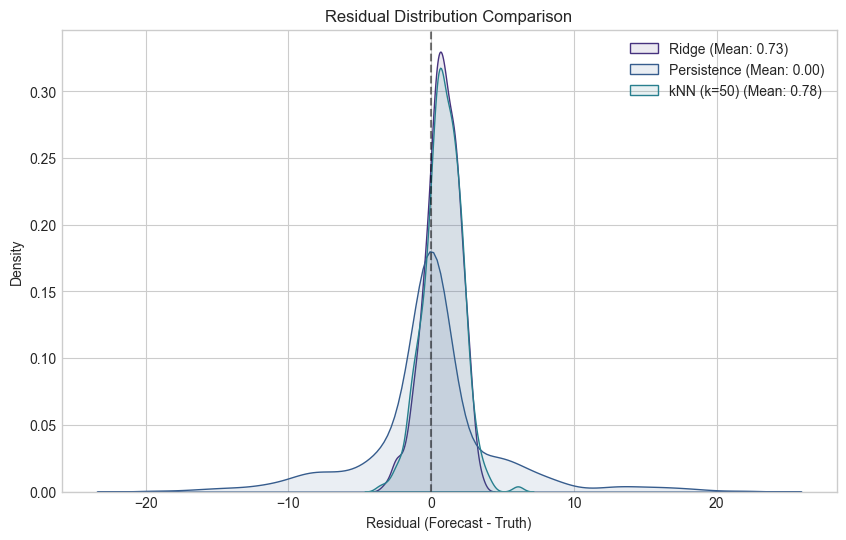

In [7]:
if results:
    fig, ax = plt.subplots(figsize=(10, 6))

    for name, data in results.items():
        res = data['residuals_df']['residual_f']
        # Use KDE for smoother comparison or Hist with step
        sns.kdeplot(res, label=f"{name} (Mean: {res.mean():.2f})", fill=True, alpha=0.1, ax=ax)

    ax.axvline(0, color='black', linestyle='--', alpha=0.5)
    ax.set_title("Residual Distribution Comparison")
    ax.set_xlabel("Residual (Forecast - Truth)")
    ax.legend()

    save_run_plot(fig, "residuals_comparison.png", run_id, base_dir=Path('../runs'))
    plt.show()


## 5. MAE by Month

Saved plot: ../runs/20260120_183019/plots/mae_by_month_comparison.png


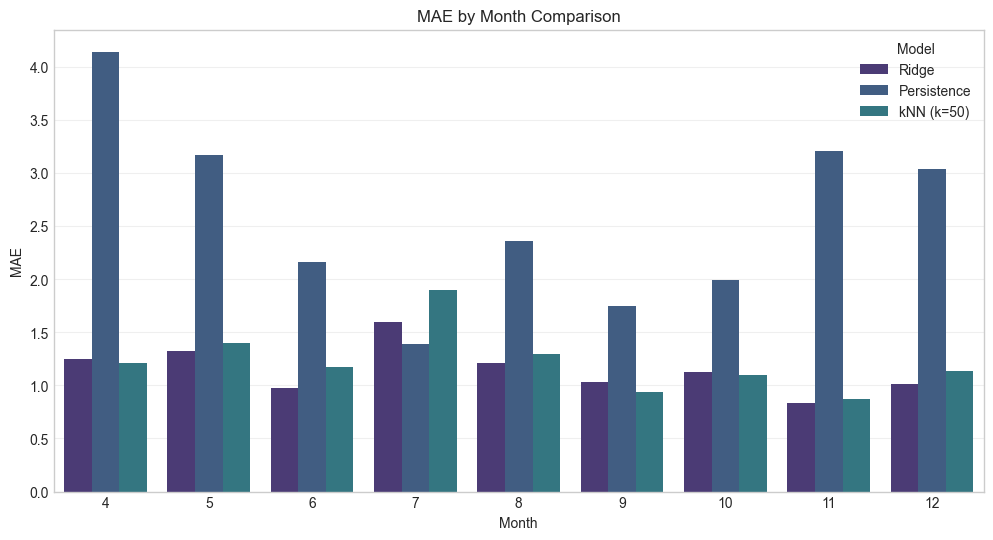

In [8]:
if results:
    # Collect monthly MAE for all models
    monthly_data = []
    for name, data in results.items():
        if data['slices'] and 'by_month' in data['slices']:
            by_month = data['slices']['by_month']
            for m, vals in by_month.items():
                monthly_data.append({
                    "Model": name,
                    "Month": int(m),
                    "MAE": vals['mae']
                })

    if monthly_data:
        df_m = pd.DataFrame(monthly_data)
        plt.figure(figsize=(12, 6))
        sns.barplot(data=df_m, x="Month", y="MAE", hue="Model")
        plt.title("MAE by Month Comparison")
        plt.grid(axis='y', alpha=0.3)
        save_run_plot(plt.gcf(), "mae_by_month_comparison.png", run_id, base_dir=Path('../runs'))
        plt.show()


## 6. MAE by Season

Saved plot: ../runs/20260120_183019/plots/mae_by_season_comparison.png


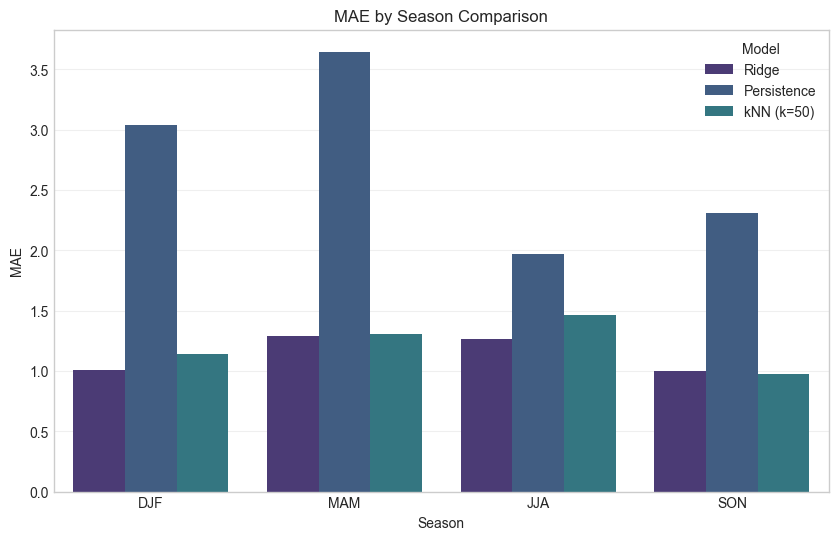

In [9]:
if results:
    seasonal_data = []
    seasons_order = ['DJF', 'MAM', 'JJA', 'SON']
    for name, data in results.items():
        if data['slices'] and 'by_season' in data['slices']:
            by_season = data['slices']['by_season']
            for s, vals in by_season.items():
                seasonal_data.append({
                    "Model": name,
                    "Season": s,
                    "MAE": vals['mae']
                })

    if seasonal_data:
        df_s = pd.DataFrame(seasonal_data)
        plt.figure(figsize=(10, 6))
        sns.barplot(data=df_s, x="Season", y="MAE", hue="Model", order=seasons_order)
        plt.title("MAE by Season Comparison")
        plt.grid(axis='y', alpha=0.3)
        save_run_plot(plt.gcf(), "mae_by_season_comparison.png", run_id, base_dir=Path('../runs'))
        plt.show()


## 7. Calibration Plot

Saved plot: ../runs/20260120_183019/plots/mae_by_lead_time.png


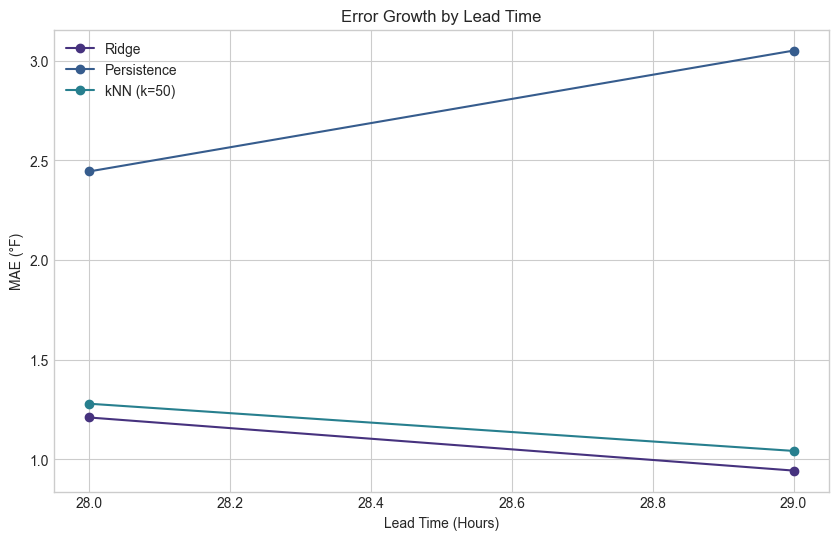

In [10]:
if results:
    # Error vs Lead Time
    plt.figure(figsize=(10, 6))

    for name, data in results.items():
        df = data['predictions_df']
        if 'lead_hours' in df.columns:
            # Calculate MAE per lead time
            df['abs_err'] = (df['y_pred_f'] - df['y_true_f']).abs()
            lead_mae = df.groupby('lead_hours')['abs_err'].mean()
            plt.plot(lead_mae.index, lead_mae.values, marker='o', label=name)

    plt.xlabel("Lead Time (Hours)")
    plt.ylabel("MAE (°F)")
    plt.title("Error Growth by Lead Time")
    plt.legend()
    plt.grid(True)
    save_run_plot(plt.gcf(), "mae_by_lead_time.png", run_id, base_dir=Path('../runs'))
    plt.show()


## 8. Prediction vs Actual Scatter

Saved plot: ../runs/20260120_183019/plots/scatter_ridge.png


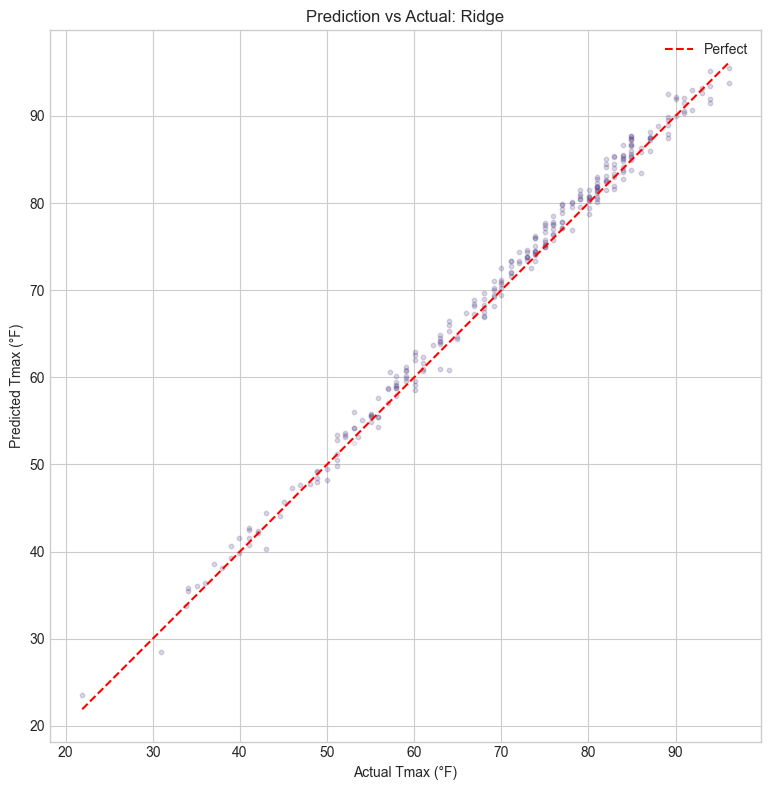

Saved plot: ../runs/20260120_183019/plots/scatter_persistence.png


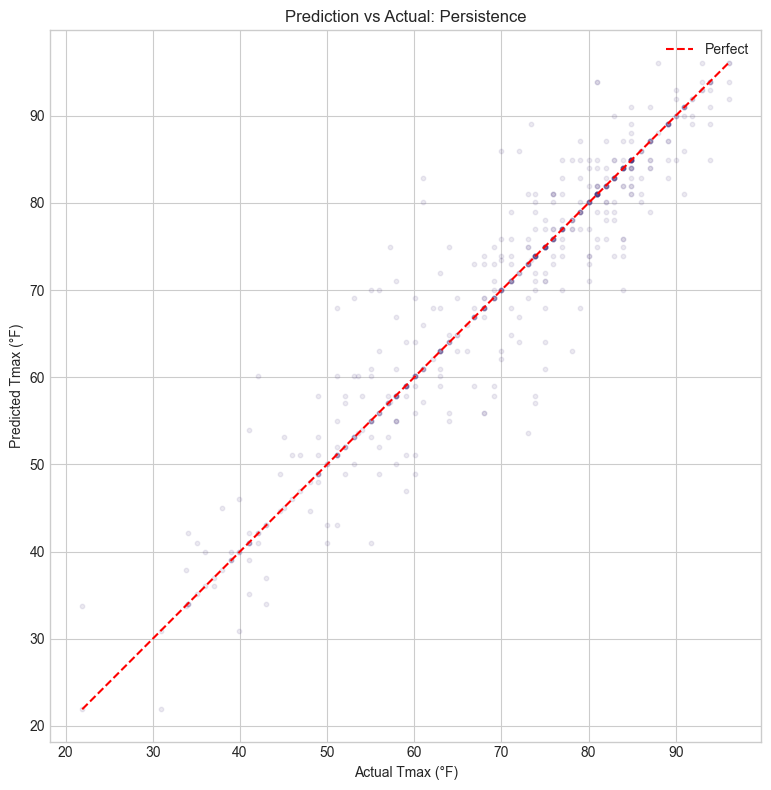

Saved plot: ../runs/20260120_183019/plots/scatter_knn_(k=50).png


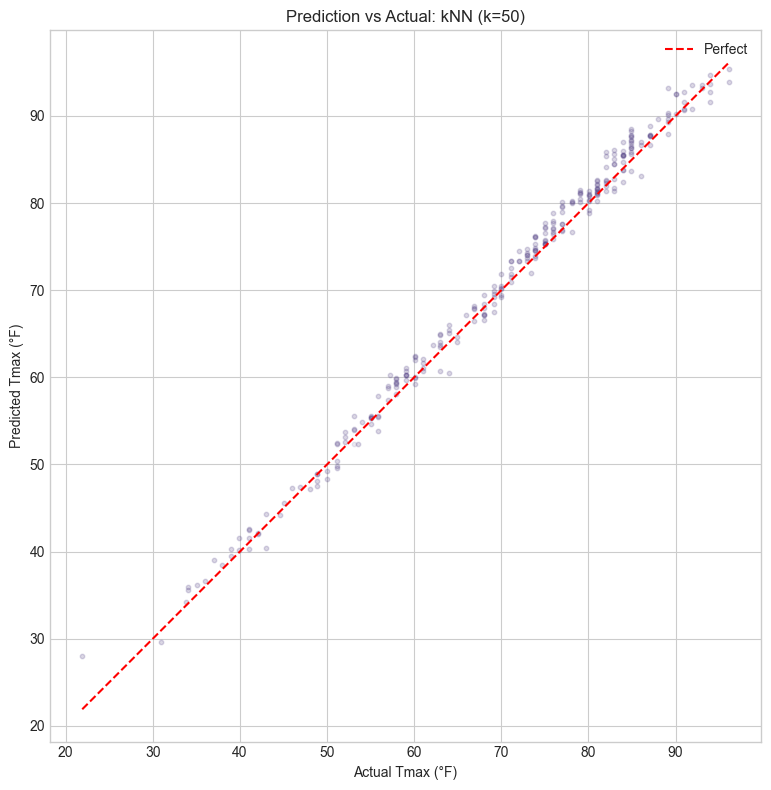

In [11]:
if results:
    for name, data in results.items():
        predictions_df = data['predictions_df']
        fig, ax = plt.subplots(figsize=(8, 8))

        x = predictions_df['y_true_f']
        y = predictions_df['y_pred_f']

        ax.scatter(x, y, alpha=0.1, s=10)

        # Perfect line
        lims = [min(x.min(), y.min()), max(x.max(), y.max())]
        ax.plot(lims, lims, 'r--', label='Perfect')

        ax.set_xlabel('Actual Tmax (°F)')
        ax.set_ylabel('Predicted Tmax (°F)')
        ax.set_title(f'Prediction vs Actual: {name}')
        ax.legend()
        ax.set_aspect('equal')
        plt.tight_layout()

        # Save plot for each model
        save_run_plot(fig, f"scatter_{name.replace(' ', '_').lower()}.png", run_id, base_dir=Path('../runs'))
        plt.show()
